In [1]:
#!c1.8
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Объединим все изображения в один датафрейм

In [2]:
#!c1.8
import os
import pandas as pd

img_path = 'Images/'

list_files = []
for dir in os.listdir(img_path):
    aux_dir = os.path.join(img_path,dir)
    if os.path.isdir(aux_dir):
        for img in os.listdir(aux_dir):
            list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

,id,label
count,19377,19377
unique,19377,10
top,Montserrat/Montserrat-MediumItalic118.jpg,Montserrat
freq,1,8982


In [3]:
#!c1.8
df['id'] = df['id'].str.replace('\\', '/')

In [4]:
#!c1.8
df.head()

,id,label
0,Inter/Inter-Bold1.jpg,Inter
1,Inter/Inter-Bold2.jpg,Inter
2,Inter/Inter-Bold3.jpg,Inter
3,Inter/Inter-Bold4.jpg,Inter
4,Inter/Inter-Bold5.jpg,Inter


In [5]:
#!c1.8
for index, row in df.iterrows():
    if row['label']=='Montserrat':
        row['label']='1'
    else: 
        row['label']='0'

In [6]:
#!c1.8
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19377 entries, 0 to 19376
Data columns (total 2 columns):
id       19377 non-null object
label    19377 non-null object
dtypes: object(2)
memory usage: 302.9+ KB


Посмотрим на сбалансированность данных

In [7]:
#!c1.8
from collections import Counter


def frequency_plot(df):
    freq_abs = Counter(df.label);
    freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
    total = len(df.index)
    freq_r = freq_a[0]/total
    freq_a[1] = freq_r
    freq_a.columns = ['Label','Absolute frequency','Relative frequency']  
    return freq_a

frequency_plot(df)

,Label,Absolute frequency,Relative frequency
0,0,10395,0.536461
1,1,8982,0.463539


Сбалансируем данные: увеличим размер классов, которым не доставало до размера таргет класса и уменьшим те, которые были слишком большими

In [8]:
#!c1.8
focus_class = '1'

focus_class_df = df[df.label == focus_class]
count_focus_class = len(focus_class_df)

In [9]:
#!c1.8
def balance_small_data(df,target_size):

    df_groups = df.groupby(['label'])
    df_balanced = pd.DataFrame({key:[] for key in df.keys()})

    for i in df_groups.groups.keys():
        df_group = df_groups.get_group(i)
        df_label = df_group.sample(frac=1)
        current_size = len(df_label)
        
        if current_size > target_size:
            continue
        else:
            repeat, mod = divmod(target_size,current_size)

            df_label_new = pd.concat([df_label]*repeat,ignore_index=True,axis=0)
            df_label_remainder = df_group.sample(n=mod)

            df_label_new = pd.concat([df_label_new,df_label_remainder],ignore_index=True,axis=0)

        df_balanced = pd.concat([df_balanced,df_label_new],ignore_index=True,axis=0)

    return df_balanced

In [10]:
#!c1.8
def balance_big_data(df, count_focus_class):
    classes = df.label.unique()
    classes_df_list = []
    
    for classe in classes:
        class_df = df[df.label == classe]
        count_class = len(class_df)
        if count_class <= count_focus_class:
            continue
        else:
            class_df = class_df.sample(count_focus_class)
        classes_df_list.append(class_df)
    df_new = pd.concat(classes_df_list, axis=0) 
    return df_new

In [11]:
#!c1.8
df_balanced_small = balance_small_data(df, count_focus_class)
df_balanced_big = balance_big_data(df, count_focus_class)

df_balanced = pd.concat([df_balanced_small,df_balanced_big],ignore_index=True)

In [12]:
#!c1.8
df_balanced.describe()

,id,label
count,17964,17964
unique,17964,2
top,Lora/Lora-Italic5.jpg,0
freq,1,8982


In [13]:
#!c1.8
frequency_plot(df_balanced)

,Label,Absolute frequency,Relative frequency
0,1,8982,0.5
1,0,8982,0.5


Разделим выборку на тренировочную, валидационную и тестовую в пропорциях 60, 20, 20 

In [14]:
#!c1.8
import numpy as np

train, validate, test = np.split(df_balanced.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

###### С помощью keras достанем изображения по пути из датафрейма

In [15]:
#!c1.8
from keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator(rescale=1. / 255)
img_width, img_height = 128, 128
batch_size = 16

train_generator = image_datagen.flow_from_dataframe(
            dataframe=train,
            directory=img_path,
            x_col="id",
            y_col="label",
            class_mode="binary",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            color_mode='grayscale'
            )

validate_generator = image_datagen.flow_from_dataframe(
            dataframe=validate,
            directory=img_path,
            x_col="id",
            y_col="label",
            class_mode="binary",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            color_mode='grayscale'
            )

test_generator = image_datagen.flow_from_dataframe(
            dataframe=test,
            directory=img_path,
            x_col="id",
            y_col="label",
            class_mode="binary",
            target_size=(img_width, img_height),
            batch_size=batch_size,
            color_mode='grayscale'
            )

Found 11626 validated image filenames belonging to 2 classes.
Found 3875 validated image filenames belonging to 2 classes.
Found 2463 validated image filenames belonging to 2 classes.


**Модель нейронной сети**

In [16]:
#!c1.8
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Bidirectional, GRU
from tensorflow.python.keras import optimizers

In [17]:
#!c1.8
input_shape = (img_width, img_height, 1)
epochs = 15
nb_train_samples = len(train)
nb_validation_samples = len(validate)
nb_test_samples = len(test)

In [18]:
#!c1.8
model = Sequential()

model.add(Conv2D(32, (3,3), activation = 'relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 2), strides=2))

model.add(Conv2D(64, (3,3), activation = 'relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 2), strides=2))

model.add(Conv2D(128, (3,3), activation = 'relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 2), strides=2))

model.add(Conv2D(256, (3,3), activation = 'relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 2), padding='same'))

#model.add(Bidirectional(GRU(256, return_sequences=True, dropout = 0.2)))

model.add(Flatten(input_shape=input_shape))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

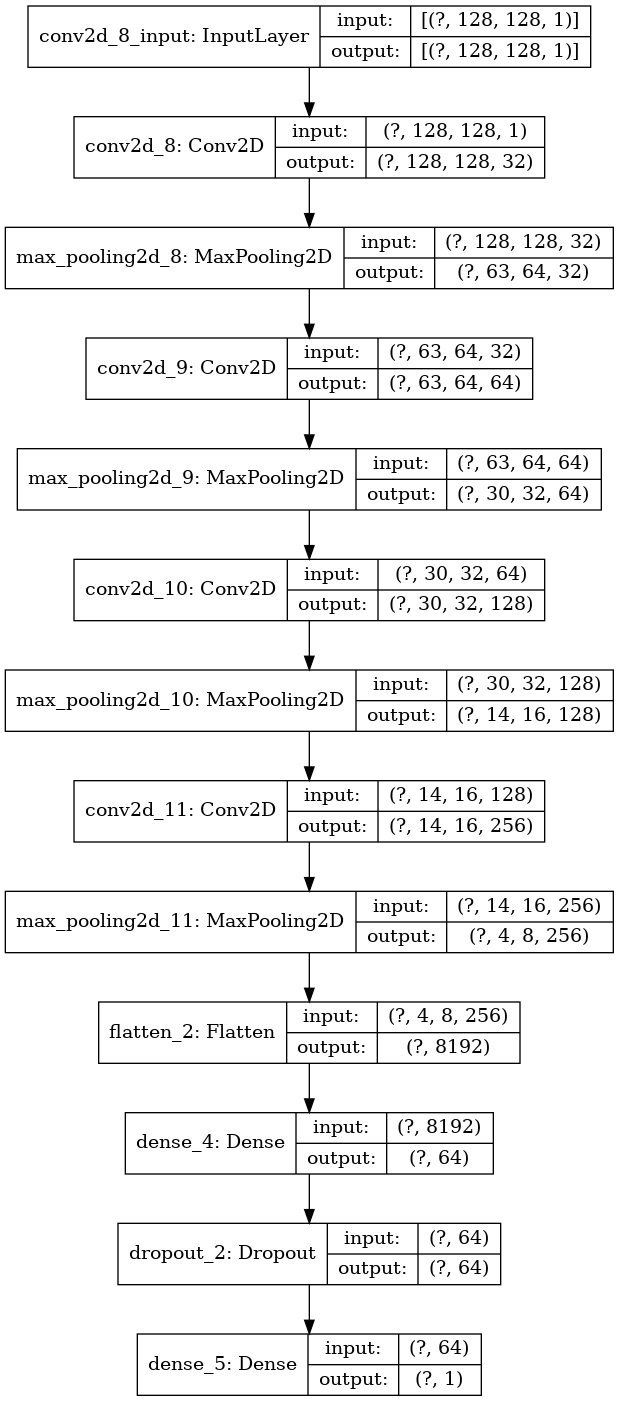

In [19]:
#!c1.8
from tensorflow.keras.utils import plot_model
plot_model(model ,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [20]:
#!c1.8
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
#!c1.8
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validate_generator,
    validation_steps=nb_validation_samples // batch_size)

726/726 [==============================] - 108s 148ms/step - loss: 0.1538 - acc: 0.9342 - val_loss: 0.2194 - val_acc: 0.9003
Epoch 9/15
726/726 [==============================] - 108s 149ms/step - loss: 0.1374 - acc: 0.9409 - val_loss: 0.2308 - val_acc: 0.9032
Epoch 10/15
726/726 [==============================] - 108s 148ms/step - loss: 0.1219 - acc: 0.9512 - val_loss: 0.3375 - val_acc: 0.8851
Epoch 11/15
726/726 [==============================] - 107s 147ms/step - loss: 0.0968 - acc: 0.9593 - val_loss: 0.2383 - val_acc: 0.9104
Epoch 12/15
726/726 [==============================] - 108s 149ms/step - loss: 0.0910 - acc: 0.9634 - val_loss: 0.2323 - val_acc: 0.9163
Epoch 13/15
726/726 [==============================] - 111s 153ms/step - loss: 0.0895 - acc: 0.9639 - val_loss: 0.2818 - val_acc: 0.9099
Epoch 14/15
726/726 [==============================] - 110s 152ms/step - loss: 0.0720 - acc: 0.9708 - val_loss: 0.3229 - val_acc: 0.9047
Epoch 15/15
726/726 [==============================] -

In [22]:
#!c1.8
model.save('model/model.h5')

In [23]:
#!c1.8
scores = model.evaluate_generator(test_generator, nb_test_samples // batch_size)
print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 89.13%


In [24]:
#!c1.8
scores = model.evaluate_generator(validate_generator, nb_test_samples // batch_size)
print("Точность на тестовых данных: %.2f%%" % (scores[1]*100))

Точность на тестовых данных: 89.83%


In [ ]:
#!c1.8
